## Step 1: Importing the libararies

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For data cleaning
import string
import spacy
import pycountry
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# For creating a pipeline for doing data cleaning
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

# For creating our model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ys723\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ys723\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 2:Grouping multiple datasets

Since we are using multiple datasets for our dataset, thus we will only take 2 columns from all 3 datasets. These 2 columns will be title and label. Finally after taking these 2 columns from all the datasets we will concatinate all 3 datasets together to get our final dataset.

In [2]:
# Let's load the train and test csv files from Kaggle folder and tsv files from the LIAR folder
kaggle_data = pd.read_csv('Datasets used/Kaggle dataset/train.csv')


# Let's load the train and test tsv files from LIAR folder
liar_test = pd.read_csv('Datasets used/LIAR dataset/test.tsv', delimiter='\t')
liar_train = pd.read_csv('Datasets used/LIAR dataset/train.tsv', delimiter='\t')
previous_data = pd.read_excel('Datasets used/Fake news challenge/Data.xlsx')
previous_data.columns = ['title','label']

In [3]:
# Extracting title and labels
kaggle_data = kaggle_data[['title','label']]

liar_train = liar_train[['Says the Annies List political group supports third-trimester abortions on demand.','false']]
liar_train.columns = ['title','label']

liar_test = liar_test[['Building a wall on the U.S.-Mexico border will take literally years.','true']]
liar_test.columns = ['title','label']

In [4]:
# Extracting only extreme labels
liar_train = liar_train[(liar_train['label'] == 'false') | (liar_train['label'] == 'true') | (liar_train['label'] == 'pants-fire')]
liar_test = liar_test[(liar_test['label'] == 'false') | (liar_test['label'] == 'true') | (liar_test['label'] == 'pants-fire')]

In [5]:
# Replacing pants pants-fire with false
liar_train['label'] = liar_train['label'].replace({'pants-fire':'false'})
liar_test['label'] = liar_test['label'].replace({'pants-fire':'false'})

In [6]:
# Combining all the datasets 
df = pd.concat([kaggle_data,liar_train,liar_test,previous_data],axis=0)

# Dropping any duplicates
df.drop_duplicates(inplace=True)

In [4]:
# Storing the file 
df.to_excel('Data.xlsx', index=False)

## Step 3:Exploratory data analysis

After concatinating all 3 datasets together our next step would be to simply explore our data so that we could get better understading of the hidden patterns within our data, which will further help us immensely during the data cleaning.

In [2]:
# Let's load the combined dataset
df = pd.read_excel('Data.xlsx')

In [3]:
# Checking the shape of the dataframe
df.shape

(43996, 2)

In [4]:
# Checking first 5 rows of the dataframe
df.head(5)

,title,target
0,"Inside Ciara's Year of ""Life and Love"": Russel...",1
1,Prince Harry and Meghan Markle Relationship Ti...,1
2,Cate Blanchett & Andrew Upton are fine… after ...,0
3,Palestinian Factions Demand ‘Day of Rage’ Duri...,0
4,Denis O’Brien Announces Bid For Irish Presidency,1


1: 'true', 0: 'false'

In [5]:
# Let's check the datatype of the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43996 entries, 0 to 43995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   43438 non-null  object
 1   target  43996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 687.6+ KB


In [6]:
# Checking any null values
df.isnull().mean()*100

title     1.268297
target    0.000000
dtype: float64

In [7]:
# Checking any duplicated values
df.duplicated().sum()

2345

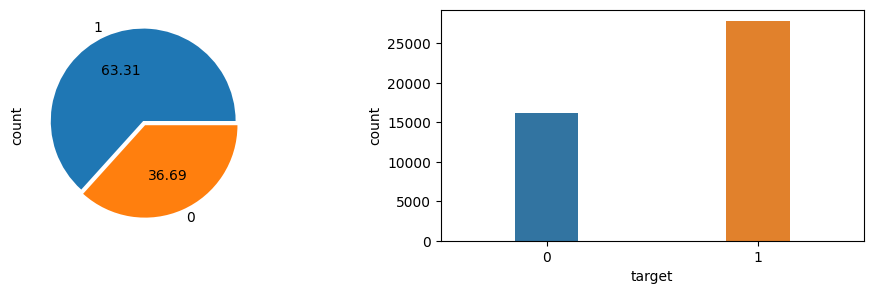

In [8]:
# Let's check distribution of data across both classes in the target variable using pie chart and bar plot
fig,ax = plt.subplots(1,2,figsize=(12,3))
ex = (0.05, 0)

df['target'].value_counts().plot(kind='pie',autopct='%.2f',explode= ex, ax=ax[0])
sns.countplot(x='target', data=df,width=0.3, ax=ax[1])

plt.subplots_adjust(wspace=0.2)
plt.show()

Now after this initial exploratory data analysis, we will first do cleaning of our data, and then we will again do some more data analysis using some more advance techiques

## Step 3: Data cleaning 

- Removal of punctuations
- Tokenization
- Lowercasing excluding country names
- Stop word removal
- Spelling check
- Stemming/lemmatization



The main difference between POS tagging and NER is that POS tags are attached to single words, while NER tags can be attached to multiple words [1]. Additionally, POS tagging is focused on identifying the part of speech of a single word, while NER is focused on identifying entities within the text, such as people, places, organizations, and events. NER also involves not only detecting the type of Named Entity [1], but also segmenting the entity from the text.

In [9]:
# Since title have some null values in it so we will simply remove them
df.dropna(inplace=True)

In [10]:
# Let's now create methods for doing data clearning

# Method for removing punctuation
def remove_punctuations(text):
    clean_text = [alphabet for alphabet in text if alphabet not in string.punctuation]
    clean_text = ''.join(clean_text)
    return clean_text

# Method for lowercasing words except the country names
country_names = set([country.name for country in pycountry.countries])
def lower_case(text):
    tokens_word = text.split()
    low = [word.lower() if word not in country_names else word for word in tokens_word]
    low = ' '.join(low)
    return low

# Method for removal of stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens_word = text.split()
    no_stop = [word for word in tokens_word if word not in stop_words]
    no_stop = ' '.join(no_stop)
    return no_stop

# Method for doing lemmatization
lemm = WordNetLemmatizer()
def lemmatize(text):
    tokens_word = text.split()
    lemm_word = [lemm.lemmatize(word) for word in tokens_word]
    lemm_word = ' '.join(lemm_word)
    return lemm_word

In [11]:
def title_prep(text):
    cleaned_text = remove_punctuations(text)
    cleaned_text = lower_case(cleaned_text)
    cleaned_text = remove_stopwords(cleaned_text)
    cleaned_text = lemmatize(cleaned_text)
    return cleaned_text

In [12]:
X_title_transformed = df['title'].apply(title_prep)
df['new_title'] = X_title_transformed

# Dropping the title column
df.drop(['title'],axis = 1,inplace=True)

After cleaning the data our next step would be to create embeddings

In [26]:
# Transformer to remove punctuations, lowercase the words, remove stop words and lemmatize
clean_data = ColumnTransformer(transformers = [('Remove_punc',FunctionTransformer(remove_punctuations),[1]),
                                               ('Lower_case',FunctionTransformer(lower_case),[1]),
                                               ('Remove_stop',FunctionTransformer(remove_stopwords),[1]),
                                               ('Lemmatize',FunctionTransformer(lemmatize),[1])],remainder='passthrough')

# define the final pipeline
pipe = Pipeline(steps=[('Clean_Data',clean_data)])

In [24]:
# Seperating the data into dependent and independent variable
X = df.drop(['target'],axis=1)
y = df['target']

# Let's split the data into train,test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Creating word embeddings and training the model

In [13]:
corpus = df['new_title'].values
voc_size = 10000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [14]:
sent_length = 30
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

In [15]:
# Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 40)            400000    
                                                                 
 dropout (Dropout)           (None, 30, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# Seperating the data into dependent and independent variables
X = np.array(embedded_docs)
y = np.array(df['target'])

# Let's do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model with early stopping callback
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
455/455 [==============================] - 21s 24ms/step - loss: 0.3833 - accuracy: 0.8326 - val_loss: 0.3244 - val_accuracy: 0.8628
Epoch 2/20
455/455 [==============================] - 10s 23ms/step - loss: 0.2685 - accuracy: 0.8897 - val_loss: 0.3197 - val_accuracy: 0.8652
Epoch 3/20
455/455 [==============================] - 10s 22ms/step - loss: 0.2336 - accuracy: 0.9028 - val_loss: 0.3432 - val_accuracy: 0.8493
Epoch 4/20
455/455 [==============================] - 9s 19ms/step - loss: 0.2052 - accuracy: 0.9158 - val_loss: 0.3559 - val_accuracy: 0.8557
Epoch 5/20
455/455 [==============================] - 10s 22ms/step - loss: 0.1759 - accuracy: 0.9287 - val_loss: 0.3873 - val_accuracy: 0.8491
Epoch 6/20
455/455 [==============================] - 10s 22ms/step - loss: 0.1509 - accuracy: 0.9400 - val_loss: 0.4379 - val_accuracy: 0.8497
Epoch 7/20
455/455 [==============================] - 10s 21ms/step - loss: 0.1282 - accuracy: 0.9512 - val_loss: 0.4761 - val_accuracy: 

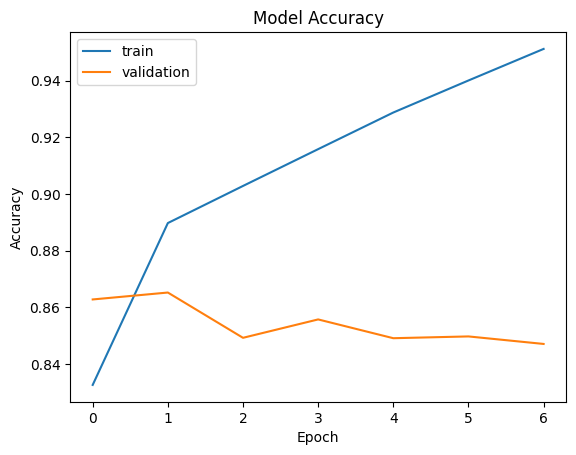

In [18]:
# Plotting the accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
# Save the model as a file using pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://50f10000-301b-4565-80c3-70ff5bcd7200/assets


INFO:tensorflow:Assets written to: ram://50f10000-301b-4565-80c3-70ff5bcd7200/assets
